# Imports

In [1]:
from collections import defaultdict
import os

import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics.pairwise import cosine_similarity

from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras import Model


# Constants

In [2]:
SAVED_MODEL_PATH = os.path.expanduser('~/Downloads/my_resnet_model-2203(1).h5')
DATASET_PATH = os.path.expanduser("~/Datasets/lfw_faces_96")
PAIR_FILE_PATH = os.path.expanduser('~/Datasets/pairsDevTrain.txt')

# Read LFW pairs

In [3]:
def read_lfw_images_dict(faces_dir: str, min_images = 0):
    faces = defaultdict(list)

    for class_entry in os.scandir(faces_dir):
        if not class_entry.is_dir():
            continue

        for image_entry in os.scandir(class_entry.path):
            face = plt.imread(image_entry.path)
            faces[class_entry.name].append(face)

    return faces


def get_lfw_pairs(faces_dir: str, pair_file_path: str):
    # read all images from dataset_path into dict with key being the name
    images = read_lfw_images_dict(faces_dir)

    pair_images = []
    pair_labels = []

    with open(pair_file_path, 'r') as f:
        n_pairs = int(f.readline())

        for i in range(n_pairs):
            line = f.readline()
            name, n1, n2 = line.strip().split('\t')
            idx1, idx2 = int(n1) - 1, int(n2) - 1
            try:
                pair_images.append((images[name][idx1], images[name][idx2]))
                pair_labels.append([1])
            except Exception as e:
                print(e)

        for i in range(n_pairs):
            line = f.readline()
            name1, n1, name2, n2 = line.strip().split('\t')
            idx1, idx2 = int(n1) - 1, int(n2) - 1
            try:
                pair_images.append((images[name1][idx1], images[name2][idx2]))
                pair_labels.append([0])
            except Exception as e:
                print(e)

        return np.array(pair_images), np.array(pair_labels)

In [4]:
X, y = get_lfw_pairs(DATASET_PATH, PAIR_FILE_PATH)
print(X.shape, y.shape)

(2200, 2, 96, 96, 3) (2200, 1)


# Create model

In [5]:
model = load_model(SAVED_MODEL_PATH)

base_model = Model(
    inputs=model.input,
    outputs=model.get_layer(name='global_avg_pool').output
)

In [6]:
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
input_zeropad (ZeroPadding2D)   (None, 102, 102, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 49, 49, 64)   4864        input_zeropad[0][0]              
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 49, 49, 64)   256         conv1[0][0]                      
______________________________________________________________________________________________

# Find the best threshold / evaluate

In [7]:
def get_accuracy_for_threshold(no_of_pairs, threshold=0.5):
    accurately_classified = 0

    for i in range(no_of_pairs):
        img_1, img_2 = X[i]

        _img_1 = preprocess_input(np.expand_dims(img_1, axis=0))
        _img_2 = preprocess_input(np.expand_dims(img_2, axis=0))

        embedding_img_1 = base_model.predict(_img_1)
        embedding_img_2 = base_model.predict(_img_2)

        similarity = cosine_similarity(embedding_img_1, embedding_img_2)

        if similarity <= threshold:
            prediction = [0]  # different people
        else:
            prediction = [1]  # same person

        if prediction == y[i]:
            accurately_classified += 1
            
    accuracy = accurately_classified / no_of_pairs    
    print(f'Dokładność dla progu {round(threshold, 2)} = {accurately_classified}/{no_of_pairs} = {round(accuracy, 3)}')
    
    return accuracy
    

In [8]:
lowest_threshold = 0.2
increment = 0.05

threshold = 0.8
results = []

while threshold >= lowest_threshold:
    accuracy = get_accuracy_for_threshold(y.size, threshold)
    results.append(accuracy)
    threshold -= increment

Dokładność dla progu 0.8 = 1589/2200 = 0.722
Dokładność dla progu 0.75 = 1836/2200 = 0.835
Dokładność dla progu 0.7 = 1947/2200 = 0.885
Dokładność dla progu 0.65 = 1954/2200 = 0.888
Dokładność dla progu 0.6 = 1868/2200 = 0.849
Dokładność dla progu 0.55 = 1703/2200 = 0.774
Dokładność dla progu 0.5 = 1505/2200 = 0.684
Dokładność dla progu 0.45 = 1357/2200 = 0.617
Dokładność dla progu 0.4 = 1241/2200 = 0.564
Dokładność dla progu 0.35 = 1165/2200 = 0.53
Dokładność dla progu 0.3 = 1116/2200 = 0.507
Dokładność dla progu 0.25 = 1102/2200 = 0.501


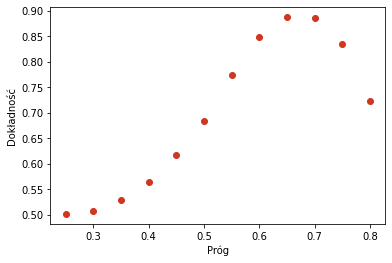

In [9]:
thresholds = np.arange(.8, .24, -.05)

fig, ax = plt.subplots()
ax.plot(thresholds, results, 'o', color="#cf3721")
ax.set_ylabel('Dokładność')
ax.set_xlabel('Próg')
#ax.set_title('Dokładność sieci na LFW względem progu')
plt.show()

In [10]:
# 2003 : 0.6 = 1941/2200 = 0.882
# 2303-2 : 0.6 = 1928/2200 = 0.876
# 2203: 0.5 = 1907/2200 = 0.867
# 2203(1): 